In [6]:
import sys
sys.path.append("../")

In [7]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from common import plot_helpers
%matplotlib inline 

In [8]:
colormap = mcolors.LinearSegmentedColormap.from_list(
    "", plt.cm.viridis.colors, N=0xFFFF)


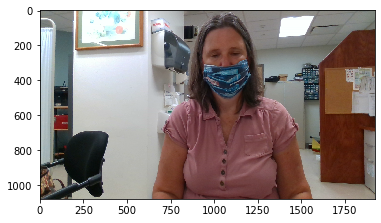

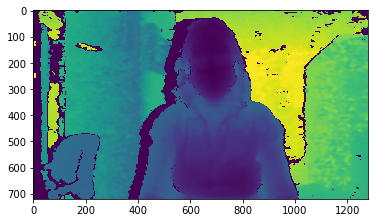

In [9]:
subj='QKZF-SWAL-UJPN'
hand='left'
file_name=f'/home/mjsobrep/Downloads/data/{subj}/target-touch/full_data-vid.hdf5'
cam='upper'
data = h5py.File(file_name, 'r')
color_idx=100
depth_idx=data['vid/lower/color/matched_depth_index'][color_idx]
img=data['vid/lower/color/data'][color_idx]
depth_img=data['vid/lower/depth/data'][depth_idx]
depth_img = plot_helpers.stretch_histogram(depth_img)
depth_img = (colormap(depth_img) * 0xFFFF).astype(np.uint16)[:, :, :3]
depth_img = cv2.cvtColor(depth_img, cv2.COLOR_RGB2BGR)
# convert from 16 to 8 bit
depth_img = cv2.convertScaleAbs(depth_img, alpha=(0xFF/0xFFFF))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB))

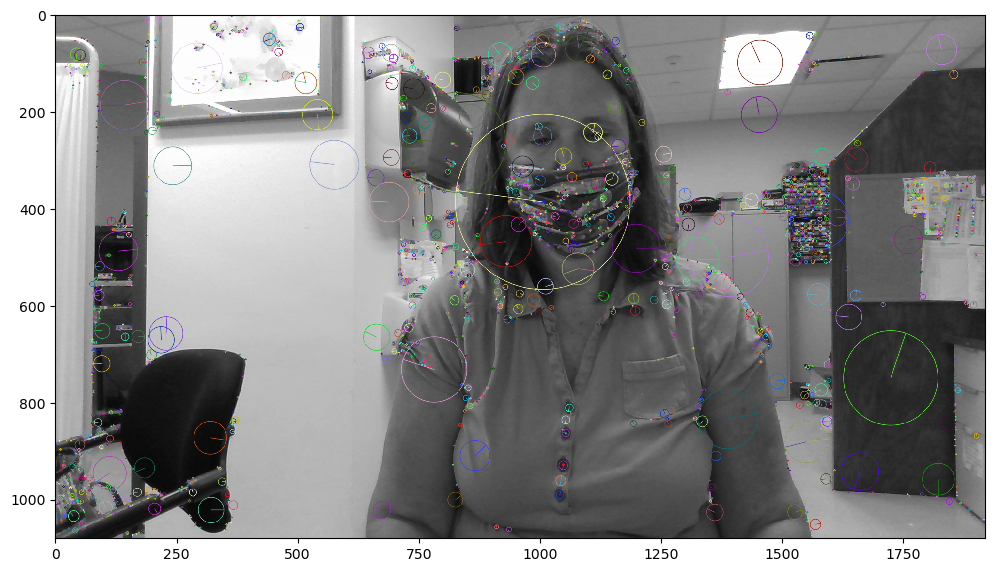

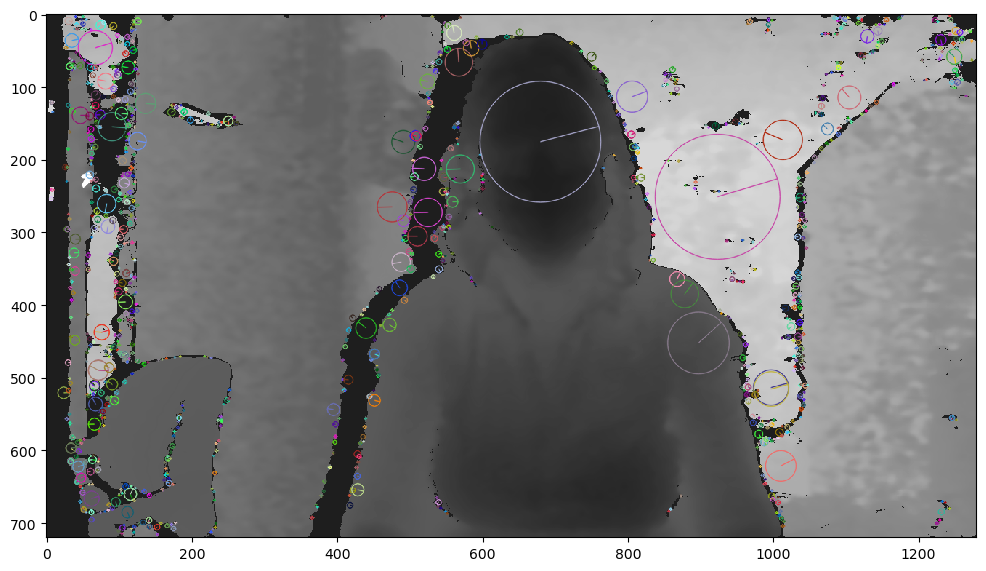

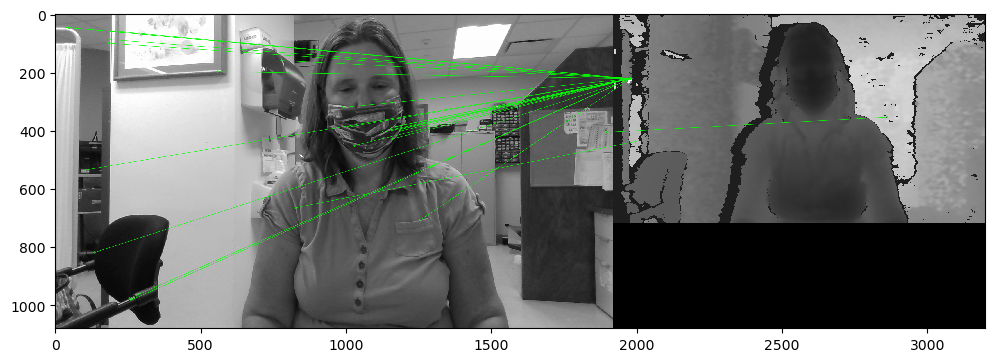

In [10]:
# https://bcmi.sjtu.edu.cn/~zhengweilong/pdf/CE86810.pdf
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
# https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

MIN_MATCH_COUNT = 10

img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img1=cv2.medianBlur(img1,5)
# img1=cv2.GaussianBlur(img1,(3,3),0)
# img1=cv2.Canny(img1, 200, 10, 3)
img2=cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
# img2=cv2.medianBlur(img2,5)
# img2=cv2.dilate(img2,None)
# img2=cv2.Canny(img2, 200, 10, 3)

# img2=cv2.Canny(img2, 100, 100)

kp1=cv2.cornerHarris(img1,2,3,0.04)
kp2=cv2.cornerHarris(img2,2,3,0.04)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# des1 = sift.compute(img1, np.array(np.where(kp1>0.01*kp1.max())).T)
# des2 = sift.compute(img2, np.array(np.where(kp2>0.01*kp1.max())).T)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img3, 'gray')